(mmm_evaluation)=
# Model Evaluation in PyMC-Marketing

This notebook demonstrates how to evaluate Marketing Mix Models using PyMC-Marketing's evaluation metrics and functions. We'll cover:

1. Standard evaluation metrics (RMSE, MAE, MAPE)
2. Normalized metrics (NRMSE, NMAE)
3. Calculating and visualizing metric distributions and summaries of those distributions
4. Creating evaluation plots (prior vs posterior plots)

First, let's import the necessary libraries:

In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import (
    root_mean_squared_error,
)

from pymc_marketing.mmm import (
    GeometricAdstock,
    LogisticSaturation,
)
from pymc_marketing.mmm.evaluation import (
    calculate_metric_distributions,
    compute_summary_metrics,
    summarize_metric_distributions,
)
from pymc_marketing.mmm.multidimensional import MMM

az.style.use("arviz-darkgrid")
plt.rcParams["figure.figsize"] = [12, 7]
plt.rcParams["figure.dpi"] = 100

%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

/opt/anaconda3/envs/pymc-marketing-dev/lib/python3.12/site-packages/pymc_extras/model/marginal/graph_analysis.py:10: FutureWarning: `pytensor.graph.basic.io_toposort` was moved to `pytensor.graph.traversal.io_toposort`. Calling it from the old location will fail in a future release.
  from pytensor.graph.basic import io_toposort


In [2]:
seed: int = sum(map(ord, "mmm-evaluation"))
rng: np.random.Generator = np.random.default_rng(seed=seed)
hdi_prob: float = 0.89  # change this to whatever HDI you want

## Setting up a Demo Model

Let's first create a simple MMM model using the example dataset:

In [3]:
# Load example data
data_url = "https://raw.githubusercontent.com/pymc-labs/pymc-marketing/main/data/mmm_example.csv"
data = pd.read_csv(data_url, parse_dates=["date_week"])

X = data.drop("y", axis=1)
y = data["y"]

# Create and fit the model
mmm = MMM(
    adstock=GeometricAdstock(l_max=8),
    saturation=LogisticSaturation(),
    date_column="date_week",
    target_column="y",
    channel_columns=["x1", "x2"],
    control_columns=[
        "event_1",
        "event_2",
        "t",
    ],
    yearly_seasonality=2,
)

fit_kwargs = {
    "tune": 1_500,
    "chains": 4,
    "draws": 2_000,
    "target_accept": 0.92,
    "random_seed": rng,
}

mmm.build_model(
    X,
    y,
)
mmm.add_original_scale_contribution_variable(
    var=["y", "channel_contribution"],
)

_ = mmm.fit(X, y, **fit_kwargs)

# Generate posterior predictive samples
posterior_preds = mmm.sample_posterior_predictive(X, random_seed=rng)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept_contribution, adstock_alpha, saturation_lam, saturation_beta, gamma_control, gamma_fourier, y_sigma]


Output()

Sampling 4 chains for 1_500 tune and 2_000 draw iterations (6_000 + 8_000 draws total) took 13 seconds.


Output()

Sampling: [y]


Output()

## Understanding the Evaluation Metrics

PyMC-Marketing provides several metrics for evaluating your models:

1. Standard metrics from scikit-learn:
   - RMSE (Root Mean Squared Error)
   - MAE (Mean Absolute Error)
   - MAPE (Mean Absolute Percentage Error)

2. Bayesian R-Squared (from `arviz.az.r2_score`)

3. Normalized metrics:
   - NRMSE (Normalized Root Mean Squared Error), such as is used by Robyn
   - NMAE (Normalized Mean Absolute Error)

Let's calculate these metrics for our model:

In [4]:
# Calculate metrics for all posterior samples
results = compute_summary_metrics(
    y_true=mmm.y,
    y_pred=posterior_preds.y_original_scale.to_numpy(),
    metrics_to_calculate=[
        "r_squared",
        "rmse",
        "nrmse",
        "mae",
        "nmae",
        "mape",
    ],
    hdi_prob=hdi_prob,
)

# Print results in a formatted way
for metric, stats in results.items():
    print(f"\n{metric.upper()}:")
    for stat, value in stats.items():
        print(f"  {stat}: {value:.4f}")


R_SQUARED:
  mean: 0.8752
  median: 0.8759
  std: 0.0126
  min: 0.8008
  max: 0.9149
  89%_hdi_lower: 0.8564
  89%_hdi_upper: 0.8959

RMSE:
  mean: 411.4603
  median: 410.7447
  std: 22.5299
  min: 333.9223
  max: 521.1570
  89%_hdi_lower: 375.9824
  89%_hdi_upper: 447.4803

NRMSE:
  mean: 0.0804
  median: 0.0802
  std: 0.0044
  min: 0.0652
  max: 0.1018
  89%_hdi_lower: 0.0734
  89%_hdi_upper: 0.0874

MAE:
  mean: 326.9824
  median: 326.5339
  std: 18.9918
  min: 261.8216
  max: 415.2958
  89%_hdi_lower: 296.4125
  89%_hdi_upper: 356.7756

NMAE:
  mean: 0.0639
  median: 0.0638
  std: 0.0037
  min: 0.0511
  max: 0.0811
  89%_hdi_lower: 0.0579
  89%_hdi_upper: 0.0697

MAPE:
  mean: 0.0644
  median: 0.0643
  std: 0.0038
  min: 0.0519
  max: 0.0827
  89%_hdi_lower: 0.0583
  89%_hdi_upper: 0.0705


`compute_summary_metrics` actually combines the steps of two other functions:

1. `calculate_metric_distributions`
2. `summarize_metric_distributions`

The metric distributions (unsummarised) can sometimes be useful on their own, e.g. if you'd like to visualise the distribution of a metric.

In [5]:
# Calculate distributions for multiple metrics
metric_distributions = calculate_metric_distributions(
    y_true=mmm.y,
    y_pred=posterior_preds.y_original_scale.to_numpy(),
    metrics_to_calculate=["rmse", "mae", "r_squared"],
)

# Summarize the distributions
summaries = summarize_metric_distributions(metric_distributions, hdi_prob=0.89)

# Create a nice display of the summaries
for metric, summary in summaries.items():
    print(f"\n{metric.upper()} Summary:")
    print(f"  Mean: {summary['mean']:.4f}")
    print(f"  Median: {summary['median']:.4f}")
    print(f"  Standard Deviation: {summary['std']:.4f}")
    print(
        f"  89% HDI: [{summary['89%_hdi_lower']:.4f}, {summary['89%_hdi_upper']:.4f}]"
    )


RMSE Summary:
  Mean: 411.4603
  Median: 410.7447
  Standard Deviation: 22.5299
  89% HDI: [375.9824, 447.4803]

MAE Summary:
  Mean: 326.9824
  Median: 326.5339
  Standard Deviation: 18.9918
  89% HDI: [296.4125, 356.7756]

R_SQUARED Summary:
  Mean: 0.8752
  Median: 0.8759
  Standard Deviation: 0.0126
  89% HDI: [0.8564, 0.8959]


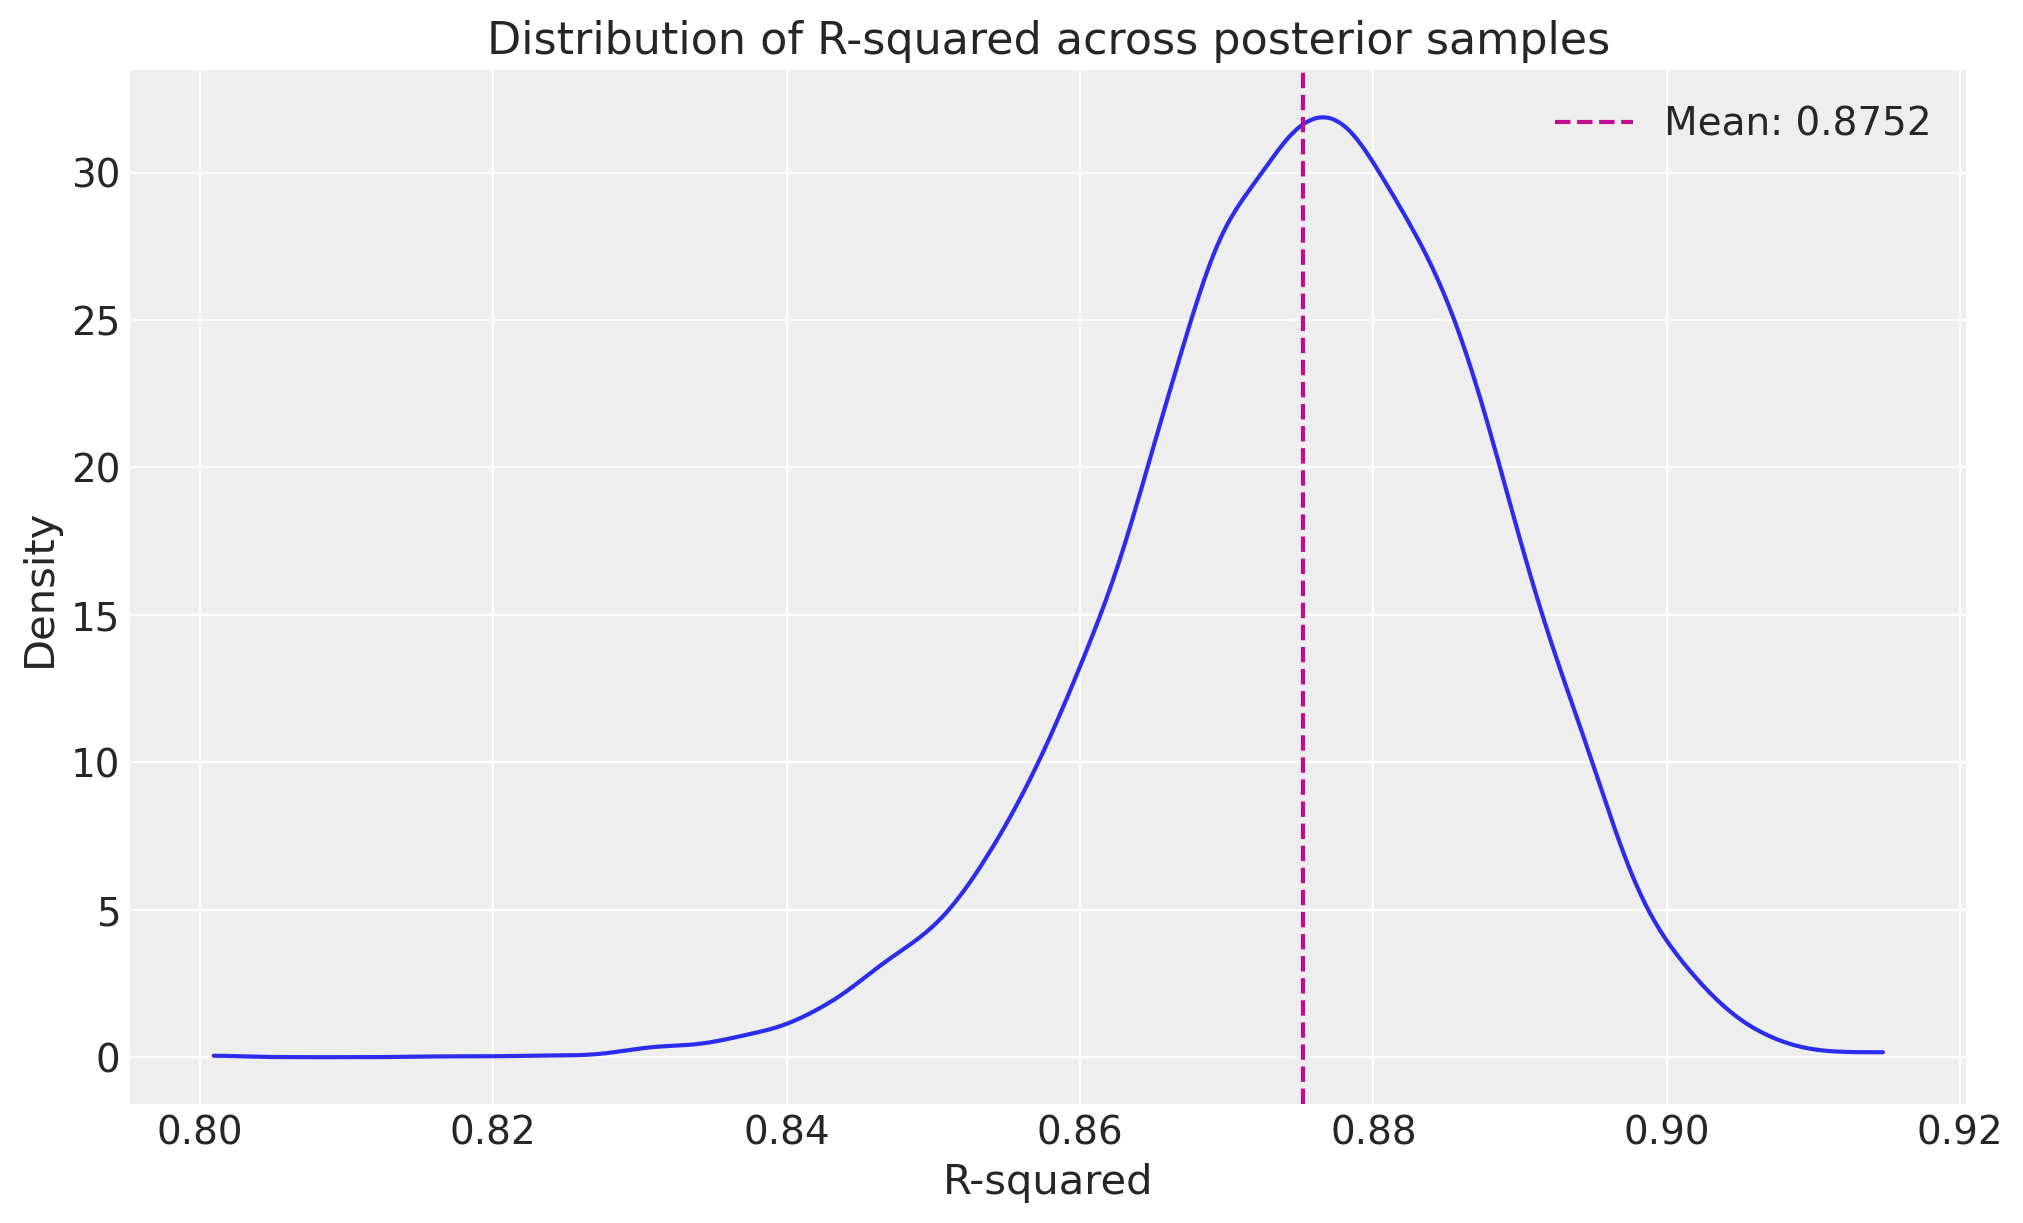

In [6]:
# Visualise the distribution of R-squared
fig, ax = plt.subplots(figsize=(10, 6))
az.plot_dist(metric_distributions["r_squared"], color="C0", ax=ax)
ax.axvline(
    summaries["r_squared"]["mean"],
    color="C3",
    linestyle="--",
    label=f"Mean: {metric_distributions['r_squared'].mean():.4f}",
)
ax.set_title("Distribution of R-squared across posterior samples")
ax.set_xlabel("R-squared")
ax.set_ylabel("Density")
ax.legend();

## Understanding Metric Distributions in Bayesian Models

In Bayesian modeling, we tend to work with distributions rather than point estimates. This is particularly important for model evaluation metrics because:

1. **E[f(x)] is not guaranteed to be f(E[x])**: This means calculating metrics on mean predictions can give different (and potentially misleading) results compared to calculating the distribution of metrics across posterior samples.

2. **Uncertainty Quantification**: Having distributions of metrics allows us to understand the uncertainty in our model's performance.

Let's demonstrate this with an example:

RMSE calculated on mean predictions: 280.9095
Mean of RMSE distribution: 411.4603


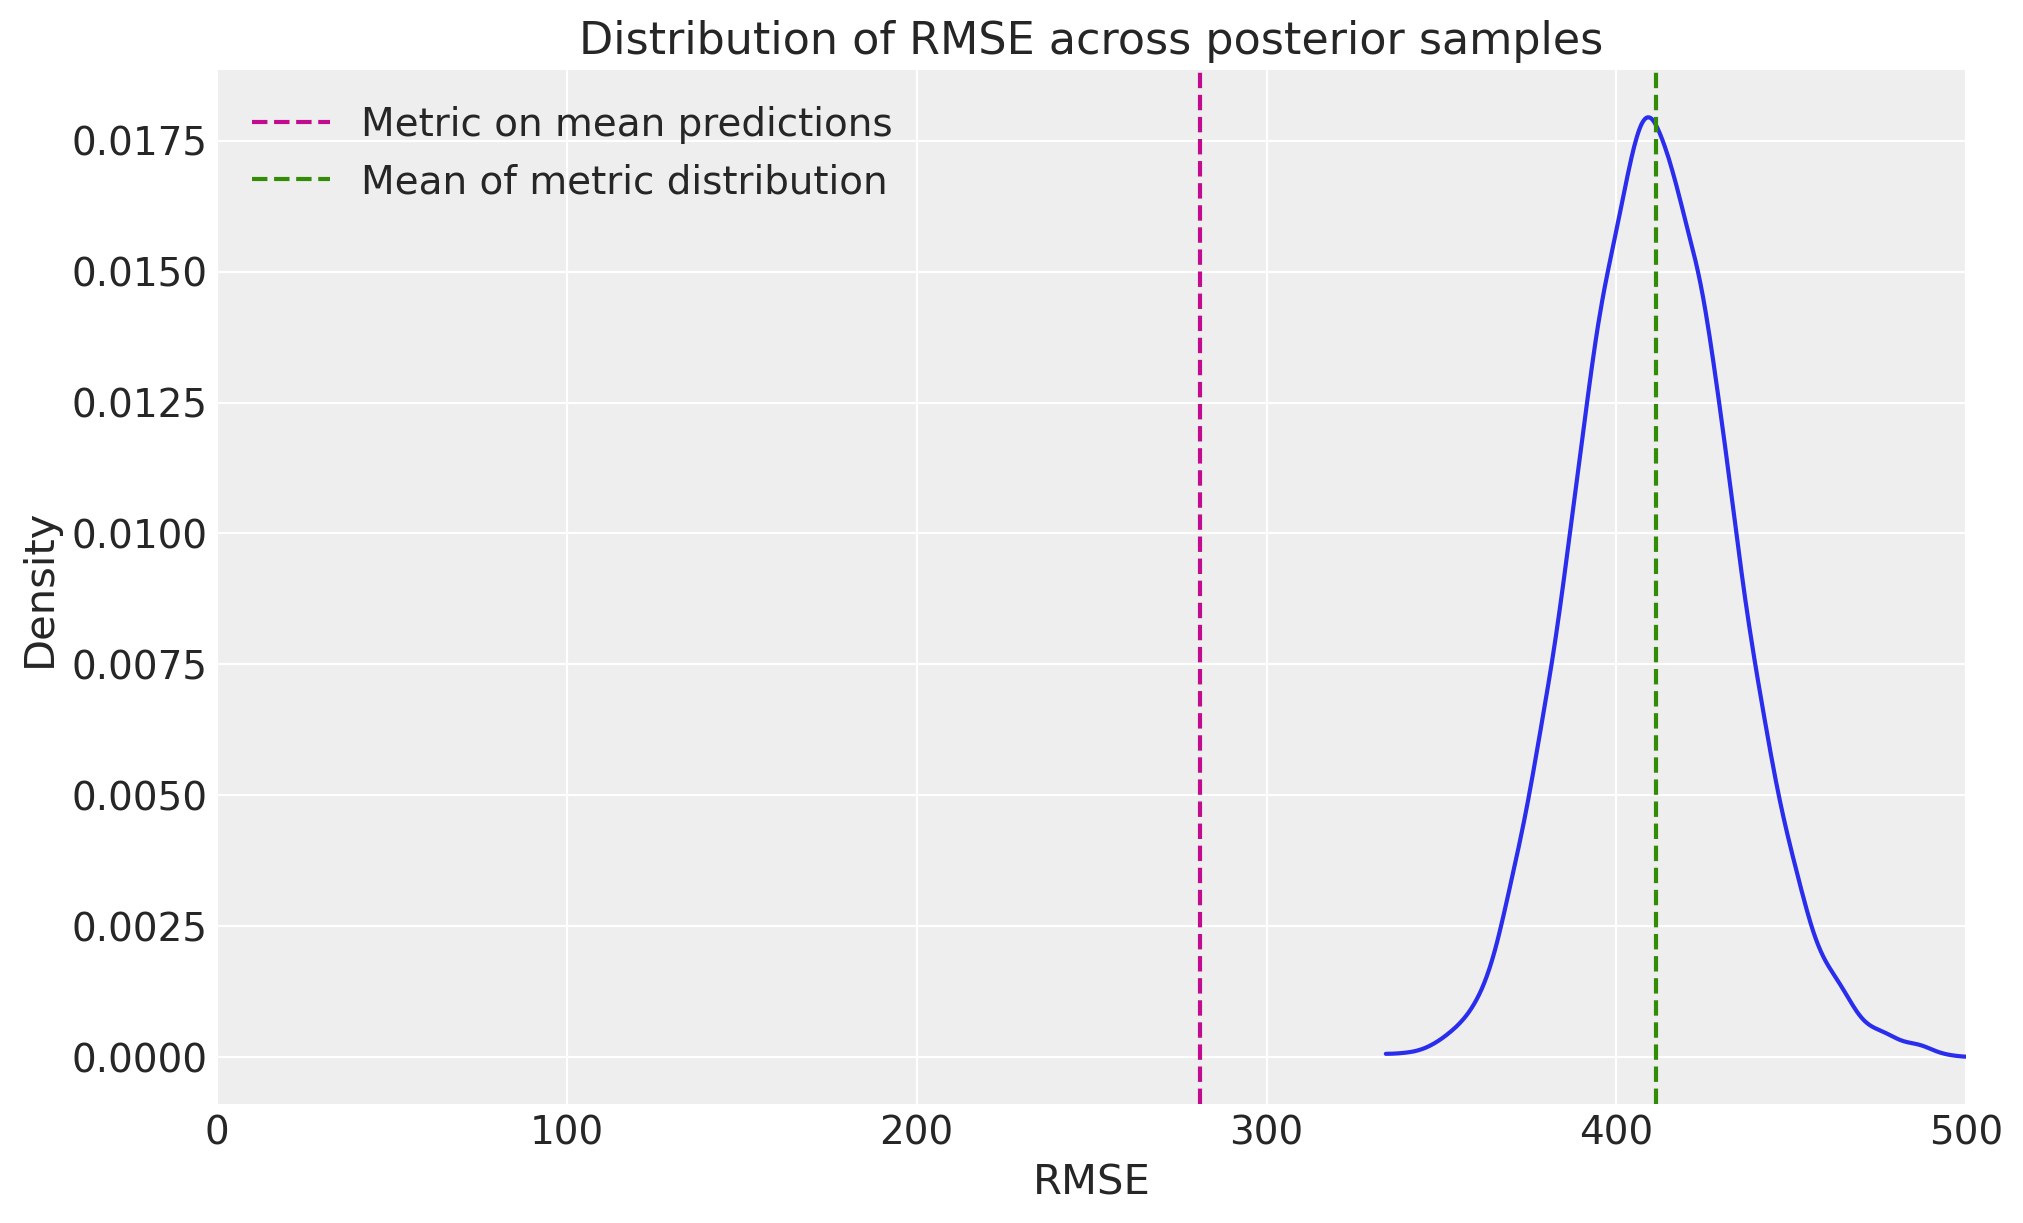

In [7]:
# Wrong way: Calculate metrics using mean predictions
mean_predictions = posterior_preds.y_original_scale.mean(axis=1)
naive_rmse = root_mean_squared_error(mmm.y, mean_predictions)

# Correct way: Calculate distribution of metrics
metric_distributions = calculate_metric_distributions(
    y_true=mmm.y, y_pred=posterior_preds.y_original_scale, metrics_to_calculate=["rmse"]
)

proper_rmse_mean = metric_distributions["rmse"].mean()

print(f"RMSE calculated on mean predictions: {naive_rmse:.4f}")
print(f"Mean of RMSE distribution: {proper_rmse_mean:.4f}")

# Visualize the RMSE distribution
fig, ax = plt.subplots(figsize=(10, 6))
az.plot_dist(metric_distributions["rmse"], color="C0", ax=ax)
ax.axvline(naive_rmse, color="C3", linestyle="--", label="Metric on mean predictions")
ax.axvline(
    proper_rmse_mean, color="C2", linestyle="--", label="Mean of metric distribution"
)
ax.set_title("Distribution of RMSE across posterior samples")
ax.set_xlim(0, 500)
ax.set_xlabel("RMSE")
ax.set_ylabel("Density")
ax.legend();

## Comparing Prior vs Posterior Distributions

We can also visualize how our prior beliefs compare to the posterior distributions using the `plot_prior_vs_posterior` method:

Sampling: [adstock_alpha, gamma_control, gamma_fourier, intercept_contribution, saturation_beta, saturation_lam, y, y_sigma]
/Users/carlostrujillo/Documents/GitHub/pymc-marketing/pymc_marketing/mmm/plot.py:1491: UserWarning: The figure layout has changed to tight
  fig.tight_layout()
/Users/carlostrujillo/Documents/GitHub/pymc-marketing/pymc_marketing/mmm/plot.py:1491: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


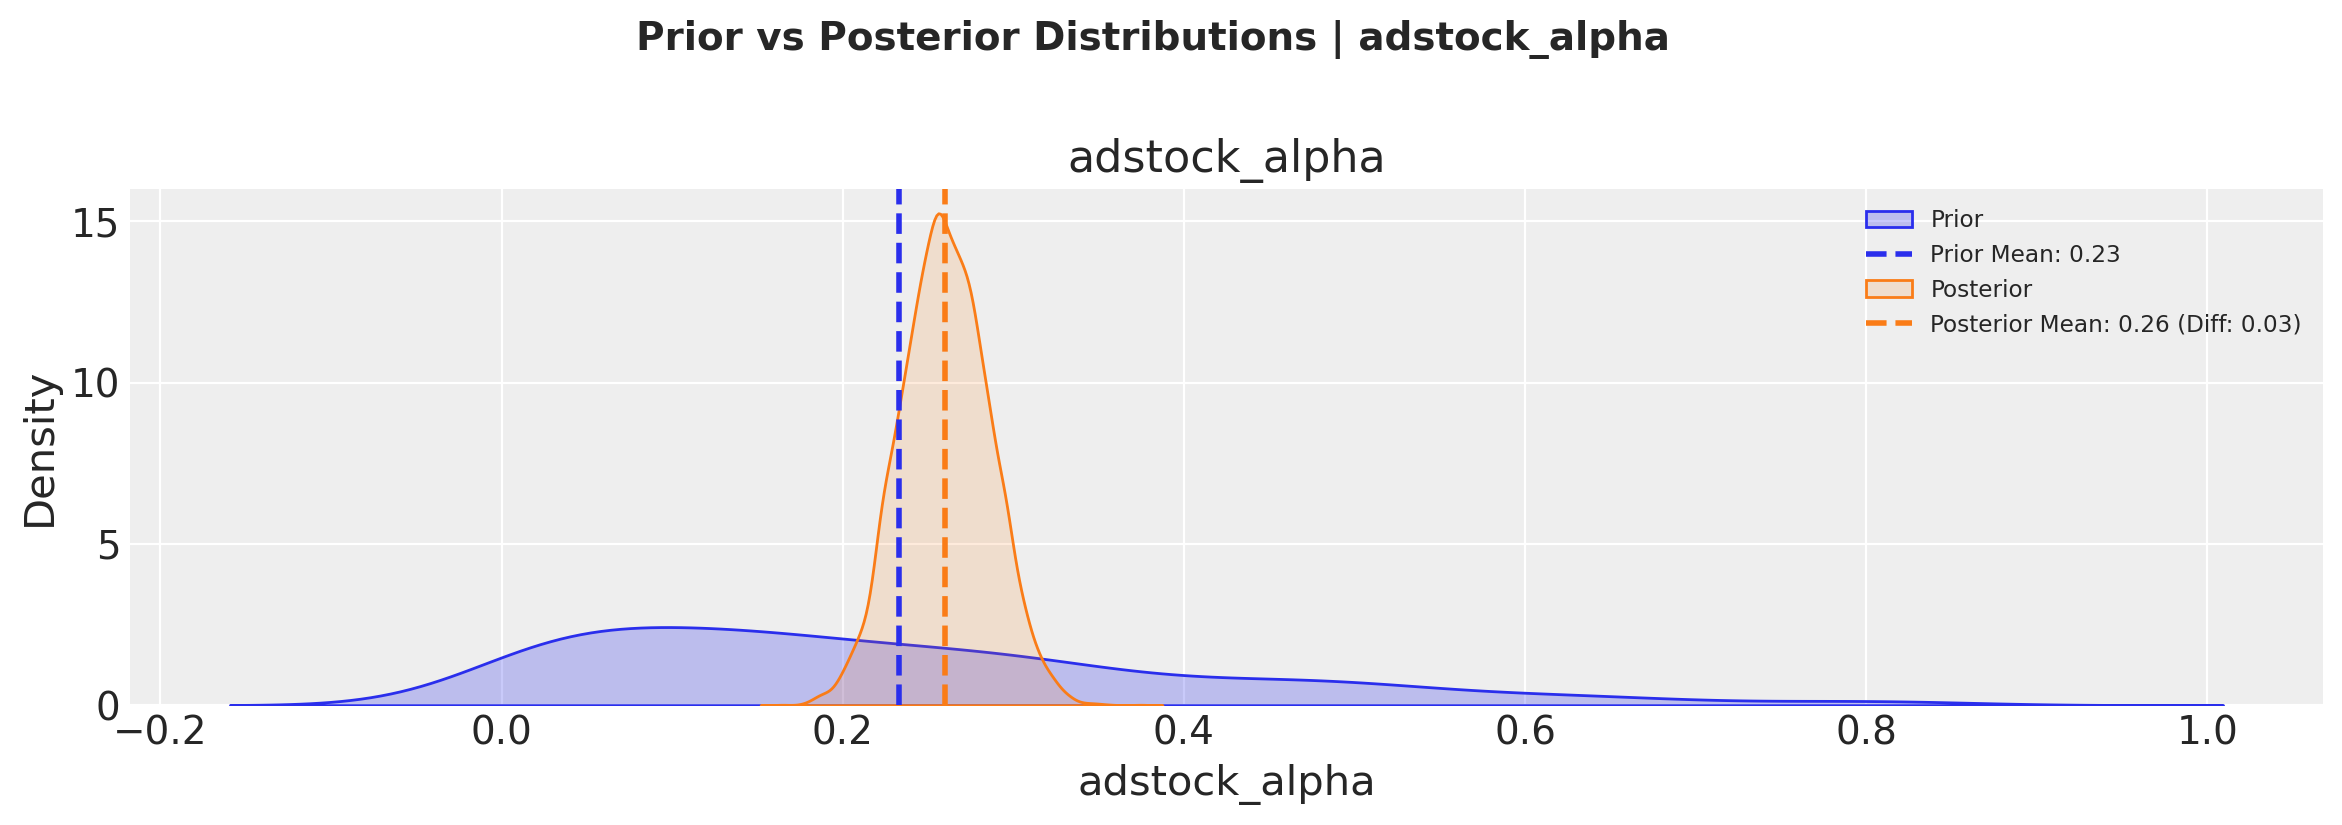

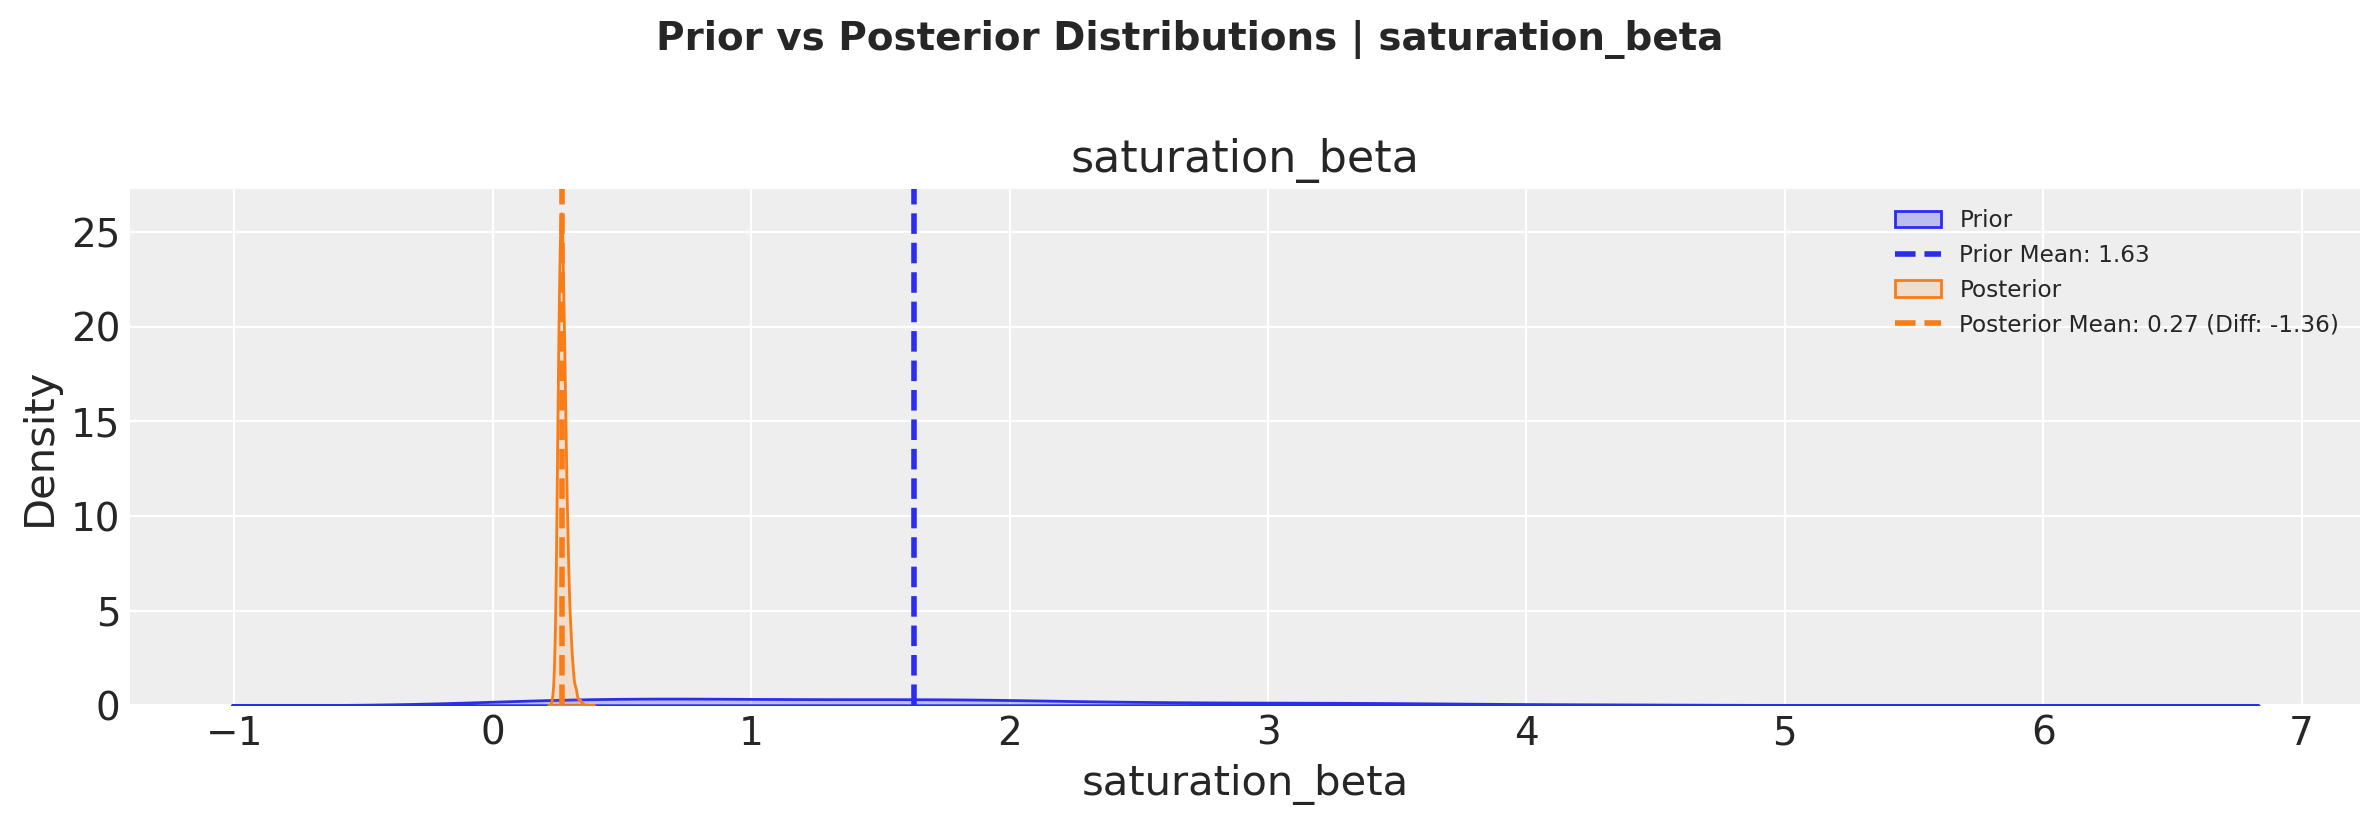

In [8]:
# First, sample from the prior
prior_preds = mmm.sample_prior_predictive(X, random_seed=rng)

# Plot prior vs posterior for adstock parameter
fig, axes = mmm.plot.prior_vs_posterior(
    var="adstock_alpha",
    alphabetical_sort=True,  # Sort channels alphabetically
)

# Plot prior vs posterior for saturation parameter
fig, axes = mmm.plot.prior_vs_posterior(
    var="saturation_beta",
    alphabetical_sort=False,  # Sort by difference between prior and posterior means
)

These visualizations help us understand:

1. How much we learned from the data (difference between prior and posterior)
2. The uncertainty in our parameter estimates (width of the distributions)
3. Whether our priors were reasonable (by comparing prior and posterior ranges)

The `plot.prior_vs_posterior` method allows us to sort channels either alphabetically or by the magnitude of change from prior to posterior, helping identify which channels had the strongest updates from the data.

## Conclusion

In this notebook, we've demonstrated how to:

1. Calculate various evaluation metrics for your MMM including normalized versions (NRMSE, NMAE), as both summaries and distributions
2. Visualize metric distributions for a chosen evaluation metric
3. Compare prior vs posterior distributions for different metrics

These tools help us understand model performance and uncertainty in our predictions, which is crucial for making informed marketing decisions.

In [9]:
%load_ext watermark
%watermark -n -u -v -iv -w -p pymc_marketing,pytensor

Last updated: Mon Jan 26 2026

Python implementation: CPython
Python version       : 3.12.11
IPython version      : 9.6.0

pymc_marketing: 0.17.1
pytensor      : 2.36.3

numpy         : 2.3.3
sklearn       : 1.7.2
pymc_marketing: 0.17.1
matplotlib    : 3.10.6
arviz         : 0.22.0
pandas        : 2.3.3

Watermark: 2.5.0

